# Moving average followed by downsampling

This notebook provide an analysis of frequently used low-pass filter, the moving average one, followed by a downsampler (also know as decimator).  

Let's suppose we have a discrete signal $x[n]$ with a certain frequency $ f$<sub>x</sub>  and we want to low-pass filter it and, at the same time, to reduce its frequency by a factor $ k $, obtaining a new signal $ y[n] $ with frequency $ f $<sub>y</sub> $=f$<sub>x</sub>$/k $.  
This result could be obtained by cascading a low-pass filter and a downsampler.

The downsampler simply selects one sample every $kth$ of them, discarding all the unused $k-1$ samples of the input signal (without zero-padding, just holding the last value put in output), thus reducing the frequency of the original signal.  
The downsampling operation can be written down as follow:

$$
  y_d[n] = x[nk+(k−1)]
$$

[The spectrum of the input signal is modified as described in this paper.](https://www.dsprelated.com/freebooks/sasp/Upsampling_Downsampling.html)  

Thus, the frequency axis is expanded by the factor $ k$, wrapping $ k$ times around the unit circle, adding to itself $ k$ times.

Proper decimation involves a digital low-pass filter in order to eliminate all components above $π/k$ (or $f_s/(2k$) ) since these components cannot be represented at the new lower sampling frequency (and will result in aliasing).
As alredy discussed and for the above mentioned purpose, we are going to place a moving average filter as first stage, whose discrete differences equation is the following:


\begin{equation*}
 y_a[n]  = \frac{1}{k} \left( \sum_{i=n-k+1}^n x[i] \right) 
\end{equation*}

Note that this is a causal filter because it uses only past samples to process the output or equivalently the impulse response of the filter is a single sided function, not equal to zero only for positive samples and in the origin (so its convolution with an input signal will take into account only the current value and the past ones, due to the flipping of $h(t)$). 

Follow a computation of the standard moving average filter (all zeros filter, BIBO stable) for k (number of averaged samples) varying between 1 and 10. We can see that the reply is a portion of the well-known sinc() function, with a main lobe an infinity sidelobes that go to zero for k * f_normalized = an integer number:


In [113]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython

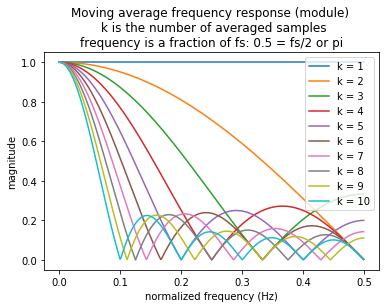

In [114]:
from scipy import signal

fs = 1   # 1Hz samples (so that we can think the x axis as a fraction of fs or 2*pi)

for k in range(0,10):
    w, h = signal.freqz(1/(k+1) * np.ones(k+1), 1)
    plt.plot((fs/2)*(w/np.pi), abs(h), label='k = ' + str(k+1));

plt.title("Moving average frequency response (module) \n k is the number of averaged samples\nfrequency is a fraction of fs: 0.5 = fs/2 or pi")
plt.xlabel("normalized frequency (Hz)");
plt.ylabel("magnitude");
plt.legend();

We are interesting in study how the moving average filter response will be modified downstream the downsampler.

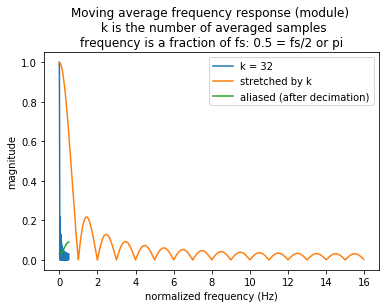

In [156]:
from scipy import signal

fs = 1   #1Hz samples (so that we can think the x axis as a fraction of fs or 2*pi)

k = 31  # decimation factor = k+1 
nas = k+1 # number of averaged samples. It's possible to make this parameter independent from k 

w, h = signal.freqz(1/(nas) * np.ones(nas), 1)
plt.plot((fs/2)*(w/np.pi), abs(h), label='k = ' + str(k+1));

# stretching operation
w_s = np.linspace(0, (k+1)*w.max(), (k+1)*w.size)
h_s = np.zeros((k+1)*h.size, dtype=complex)

for i in range(0, w_s.size):
    h_s[i]=np.interp(w_s[i]/(k+1), w, h)

plt.plot((fs/2)*(w_s/np.pi), abs(h_s), label='stretched by k');

# aliasing operation, implement folding (frequency spectrum folds as an accordion)
h_a = np.zeros(h.size, dtype=complex)
 
for i in range(0, k+1):
    if (i % 2 != 0): # odd: the band is aliased in reversed way 
        h_a = h_a + np.flip(h_s[i*h_a.size:(i+1)*h_a.size],0)
        #h_a = h_a + np.zeros(h_a.size)
    else: #even: the band is directly aliased
        h_a = h_a + h_s[i*h_a.size:(i+1)*h_a.size]
        #h_a = h_a + np.zeros(h_a.size)

# divide by the decimation factor
h_a = (1/(k+1)) * h_a

plt.plot((fs/2)*(w/np.pi), abs(h_a), label='aliased (after decimation)');
        
plt.title("Moving average frequency response (module) \n k is the number of averaged samples\nfrequency is a fraction of fs: 0.5 = fs/2 or pi")
plt.xlabel("normalized frequency (Hz)");
plt.ylabel("magnitude");
plt.legend();

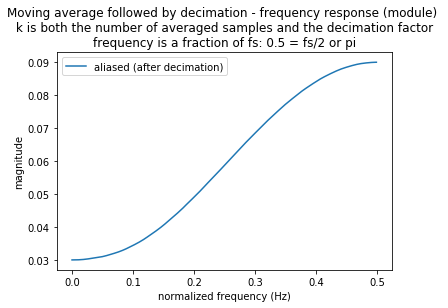

In [157]:
plt.plot((fs/2)*(w/np.pi), abs(h_a), label='aliased (after decimation)');
        
plt.title("Moving average followed by decimation - frequency response (module) \n k is both the number of averaged samples and the decimation factor \nfrequency is a fraction of fs: 0.5 = fs/2 or pi")
plt.xlabel("normalized frequency (Hz)");
plt.ylabel("magnitude");
plt.legend();

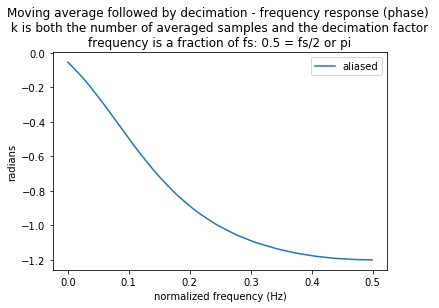

In [158]:
plt.plot((fs/2)*(w/np.pi), np.angle(h_a), label='aliased');

plt.title("Moving average followed by decimation - frequency response (phase) \n k is both the number of averaged samples and the decimation factor \nfrequency is a fraction of fs: 0.5 = fs/2 or pi")
plt.xlabel("normalized frequency (Hz)");
plt.ylabel("radians");
plt.legend();

[The overall filter is classified as a polyphase filter bank.](https://www.dsprelated.com/freebooks/sasp/Filtering_Downsampling.html)